## Imports ##

In [90]:
import os
import pickle
import json
import joblib

import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd

import mne
from mne import events_from_annotations

from sklearn.model_selection import train_test_split
from scipy.interpolate import CubicSpline
from scipy.integrate import simps
from sklearn.metrics import r2_score

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,Matern,RationalQuadratic,ExpSineSquared

from sklearn.metrics import classification_report, accuracy_score

from processing.Processing_EEG import process_eeg
from processing.Processing_NIRS import process_nirs

from utilities.Read_Data import read_subject_raw_nirs, read_subject_raw_eeg
from utilities.utilities import translate_channel_name_to_ch_id, find_sections, spatial_zscore

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F



## Constants ##

In [91]:
BASE_PATH = '/Users/mm/dev/super_resolution/eeg_fNIRs/shin_2017/data/'

ROOT_DIRECTORY_EEG = os.path.join(BASE_PATH, 'raw/eeg/')
ROOT_DIRECTORY_NIRS = os.path.join(BASE_PATH, 'raw/nirs/')

# Trial order
TRIAL_TO_CHECK_NIRS = {'VP001': {
                            'nback': ['2016-05-26_007', '2016-05-26_008', '2016-05-26_009',],
                            'gonogo': ['2016-05-26_001', '2016-05-26_002', '2016-05-26_003',],
                            'word': ['2016-05-26_004', '2016-05-26_005', '2016-05-26_006',]
                        },
                        'VP002': {
                            'nback': ['2016-05-26_016', '2016-05-26_017', '2016-05-26_018',],
                            'gonogo': ['2016-05-26_010', '2016-05-26_011', '2016-05-26_012',],
                            'word': ['2016-05-26_013', '2016-05-26_014', '2016-05-26_015',]
                        },
                        'VP003': {
                            'nback': ['2016-05-27_001', '2016-05-27_002', '2016-05-27_003',],
                            'gonogo': ['2016-05-27_007', '2016-05-27_008', '2016-05-27_009',],
                            'word': ['2016-05-27_004', '2016-05-27_005', '2016-05-27_006',]
                        },
                        'VP004': {
                            'nback': ['2016-05-30_001', '2016-05-30_002', '2016-05-30_003'],
                            'gonogo': ['2016-05-30_007', '2016-05-30_008', '2016-05-30_009'],
                            'word': ['2016-05-30_004', '2016-05-30_005', '2016-05-30_006']
                        },
                        'VP005': {
                            'nback': ['2016-05-30_010', '2016-05-30_011', '2016-05-30_012'],
                            'gonogo': ['2016-05-30_016', '2016-05-30_017', '2016-05-30_018'],
                            'word': ['2016-05-30_013', '2016-05-30_014', '2016-05-30_015']
                        },
                        'VP006': {
                            'nback': ['2016-05-31_001', '2016-05-31_002', '2016-05-31_003'],
                            'gonogo': ['2016-05-31_007', '2016-05-31_008', '2016-05-31_009'],
                            'word': ['2016-05-31_004', '2016-05-31_005', '2016-05-31_006']
                        },
                        'VP007': {
                            'nback': ['2016-06-01_001', '2016-06-01_002', '2016-06-01_003'],
                            'gonogo': ['2016-06-01_007', '2016-06-01_008', '2016-06-01_009'],
                            'word': ['2016-06-01_004', '2016-06-01_005', '2016-06-01_006']
                        },
                        'VP008': {
                            'nback': ['2016-06-02_001', '2016-06-02_002', '2016-06-02_003'],
                            'gonogo': ['2016-06-02_007', '2016-06-02_008', '2016-06-02_009'],
                            'word': ['2016-06-02_004', '2016-06-02_005', '2016-06-02_006']
                        },
                        'VP009': {
                            'nback': ['2016-06-02_010', '2016-06-02_011', '2016-06-02_012'],
                            'gonogo': ['2016-06-02_016', '2016-06-02_017', '2016-06-02_018'],
                            'word': ['2016-06-02_013', '2016-06-02_014', '2016-06-02_015']
                        },
                        'VP010': {
                            'nback': ['2016-06-03_001', '2016-06-03_002', '2016-06-03_003'],
                            'gonogo': ['2016-06-03_007', '2016-06-03_008', '2016-06-03_009'],
                            'word': ['2016-06-03_004', '2016-06-03_005', '2016-06-03_006']
                        },
                        'VP011': {
                            'nback': ['2016-06-03_010', '2016-06-03_011', '2016-06-03_012'],
                            'gonogo': ['2016-06-03_016', '2016-06-03_017', '2016-06-03_018'],
                            'word': ['2016-06-03_013', '2016-06-03_014', '2016-06-03_015']
                        },'VP012': {
                            'nback': ['2016-06-06_001', '2016-06-06_002', '2016-06-06_003'],
                            'gonogo': ['2016-06-06_007', '2016-06-06_008', '2016-06-06_009'],
                            'word': ['2016-06-06_004', '2016-06-06_005', '2016-06-06_006']
                        },'VP013': {
                            'nback': ['2016-06-06_010', '2016-06-06_011', '2016-06-06_012'],
                            'gonogo': ['2016-06-06_016', '2016-06-06_017', '2016-06-06_018'],
                            'word': ['2016-06-06_013', '2016-06-06_014', '2016-06-06_015']
                        },'VP014': {
                            'nback': ['2016-06-07_001', '2016-06-07_002', '2016-06-07_003'],
                            'gonogo': ['2016-06-07_007', '2016-06-07_008', '2016-06-07_009'],
                            'word': ['2016-06-07_004', '2016-06-07_005', '2016-06-07_006']
                        },'VP015': {
                            'nback': ['2016-06-07_010', '2016-06-07_011', '2016-06-07_012'],
                            'gonogo': ['2016-06-07_016', '2016-06-07_017', '2016-06-07_018'],
                            'word': ['2016-06-07_013', '2016-06-07_014', '2016-06-07_015']
                        },'VP016': {
                            'nback': ['2016-06-08_001', '2016-06-08_002', '2016-06-08_003'],
                            'gonogo': ['2016-06-08_007', '2016-06-08_008', '2016-06-08_009'],
                            'word': ['2016-06-08_004', '2016-06-08_005', '2016-06-08_006']
                        },'VP017': {
                            'nback': ['2016-06-09_001', '2016-06-09_002', '2016-06-09_003'],
                            'gonogo': ['2016-06-09_007', '2016-06-09_008', '2016-06-09_009'],
                            'word': ['2016-06-09_004', '2016-06-09_005', '2016-06-09_006']
                        },'VP018': {
                            'nback': ['2016-06-10_001', '2016-06-10_002', '2016-06-10_003'],
                            'gonogo': ['2016-06-10_007', '2016-06-10_008', '2016-06-10_009'],
                            'word': ['2016-06-10_004', '2016-06-10_005', '2016-06-10_006']
                        },'VP019': {
                            'nback': ['2016-06-13_001', '2016-06-13_002', '2016-06-13_003'],
                            'gonogo': ['2016-06-13_007', '2016-06-13_008', '2016-06-13_009'],
                            'word': ['2016-06-13_004', '2016-06-13_005', '2016-06-13_006']
                        },'VP020': {
                            'nback': ['2016-06-14_001', '2016-06-14_002', '2016-06-14_003'],
                            'gonogo': ['2016-06-14_007', '2016-06-14_008', '2016-06-14_009'],
                            'word': ['2016-06-14_004', '2016-06-14_005', '2016-06-14_006']
                        },'VP021': {
                            'nback': ['2016-06-14_010', '2016-06-14_011', '2016-06-14_012'],
                            'gonogo': ['2016-06-14_016', '2016-06-14_017', '2016-06-14_018'],
                            'word': ['2016-06-14_013', '2016-06-14_014', '2016-06-14_015']
                        },'VP022': {
                            'nback': ['2016-06-15_001', '2016-06-15_002', '2016-06-15_003'],
                            'gonogo': ['2016-06-15_007', '2016-06-15_008', '2016-06-15_009'],
                            'word': ['2016-06-15_004', '2016-06-15_005', '2016-06-15_006']
                        },'VP023': {
                            'nback': ['2016-06-16_001', '2016-06-16_002', '2016-06-16_003'],
                            'gonogo': ['2016-06-16_007', '2016-06-16_008', '2016-06-16_009'],
                            'word': ['2016-06-16_004', '2016-06-16_005', '2016-06-16_006']
                        },'VP024': {
                            'nback': ['2016-06-16_010', '2016-06-16_011', '2016-06-16_012'],
                            'gonogo': ['2016-06-16_016', '2016-06-16_017', '2016-06-16_018'],
                            'word': ['2016-06-16_013', '2016-06-16_014', '2016-06-16_015']
                        },
                        'VP025': {
                            'nback': ['2016-06-17_010', '2016-06-17_011', '2016-06-17_012',],
                            'gonogo': ['2016-06-17_016', '2016-06-17_017', '2016-06-17_018',],
                            'word': ['2016-06-17_013', '2016-06-17_014', '2016-06-17_015',]
                        },
                        'VP026': {
                            'nback': ['2016-07-11_001', '2016-07-11_002', '2016-07-11_003',],
                            'gonogo': ['2016-07-11_007', '2016-07-11_008', '2016-07-11_009',],
                            'word': ['2016-07-11_004', '2016-07-11_005', '2016-07-11_006',]
                        }
                    }

# Task translation dictionaries
EEG_EVENT_TRANSLATIONS = {
            'nback': {
                'Stimulus/S 16': '0-back target',
                'Stimulus/S 48': '2-back target',
                'Stimulus/S 64': '2-back non-target',
                'Stimulus/S 80': '3-back target',
                'Stimulus/S 96': '3-back non-target',
                'Stimulus/S112': '0-back session',
                'Stimulus/S128': '2-back session',
                'Stimulus/S144': '3-back session'},
            'gonogo': {
                'Stimulus/S 16': 'go',
                'Stimulus/S 32': 'nogo',
                'Stimulus/S 48': 'gonogo session'},
            'word': {
                'Stimulus/S 16': 'verbal_fluency',
                'Stimulus/S 32': 'baseline'}
}
NIRS_EVENT_TRANSLATIONS = {
    'nback': {
        '7.0': '0-back session',
        '8.0': '2-back session',
        '9.0': '3-back session'},
    'gonogo': {
        '3.0': 'gonogo session'},
    'word': {
        '1.0': 'verbal_fluency',
        '2.0': 'baseline'}
}

# Sub tasks to crop times to for same length
TASK_STIMULOUS_TO_CROP = {'nback': ['0-back session', '2-back session', '3-back session'],
                            'gonogo': ['gonogo session'],
                            'word': ['verbal_fluency', 'baseline']
                            }

# EEG Coordinates
EEG_COORDS = {'FP1':(-0.3090,0.9511,0.0001), #Fp1
                'AFF5':(-0.5417,0.7777,0.3163), #AFF5h
                'AFz':(0.0000,0.9230,0.3824),
                'F1':(-0.2888,0.6979,0.6542),
                'FC5':(-0.8709,0.3373,0.3549),
                'FC1':(-0.3581,0.3770,0.8532),
                'T7':(-1.0000,0.0000,0.0000),
                'C3':(-0.7066,0.0001,0.7066),
                'Cz':(0.0000,0.0002,1.0000),
                'CP5':(-0.8712,-0.3372,0.3552),
                'CP1':(-0.3580,-0.3767,0.8534),
                'P7':(-0.8090,-0.5878,-0.0001),
                'P3':(-0.5401,-0.6724,0.5045),
                'Pz':(0.0000,-0.7063,0.7065),
                'POz':(0.0000,-0.9230,0.3824),
                'O1':(-0.3090,-0.9511,0.0000),
                'FP2':(0.3091,0.9511,0.0000), #Fp2
                'AFF6':(0.5417,0.7777,0.3163), #AFF6h
                'F2':(0.2888,0.6979,0.6542),
                'FC2':(0.3581,0.3770,0.8532),
                'FC6':(0.8709,0.3373,0.3549),
                'C4':(0.7066,0.0001,0.7066),
                'T8':(1.0000,0.0000,0.0000),
                'CP2':(0.3580,-0.3767,0.8534),
                'CP6':(0.8712,-0.3372,0.3552),
                'P4':(0.5401,-0.6724,0.5045),
                'P8':(0.8090,-0.5878,-0.0001),
                'O2':(0.3090,-0.9511,0.0000),
                'TP9':(-0.8777,-0.2852,-0.3826),
                'TP10':(0.8777,-0.2853,-0.3826),
                
                'Fp1':(-0.3090,0.9511,0.0001),
                'AFF5h':(-0.5417,0.7777,0.3163),
                'Fp2':(0.3091,0.9511,0.0000),
                'AFF6h':(0.5417,0.7777,0.3163),}

# NIRS Ccoordinates
NIRS_COORDS = {
    'AF7':(-0.5878,0.809,0),
    'AFF5':(-0.6149,0.7564,0.2206),
    'AFp7':(-0.454,0.891,0),
    'AF5h':(-0.4284,0.875,0.2213),
    'AFp3':(-0.2508,0.9565,0.1438),
    'AFF3h':(-0.352,0.8111,0.4658),
    'AF1':(-0.1857,0.915,0.3558),
    'AFFz':(0,0.8312,0.5554),
    'AFpz':(0,0.9799,0.1949),
    'AF2':(0.1857,0.915,0.3558),
    'AFp4':(0.2508,0.9565,0.1437),
    'FCC3':(-0.6957,0.1838,0.6933),
    'C3h':(-0.555,0.0002,0.8306),
    'C5h':(-0.8311,0.0001,0.5552),
    'CCP3':(-0.6959,-0.1836,0.6936),
    'CPP3':(-0.6109,-0.5259,0.5904),
    'P3h':(-0.4217,-0.6869,0.5912),
    'P5h':(-0.6411,-0.6546,0.3985),
    'PPO3':(-0.4537,-0.796,0.3995),
    'AFF4h':(0.352,0.8111,0.4658),
    'AF6h':(0.4284,0.875,0.2212),
    'AFF6':(0.6149,0.7564,0.2206),
    'AFp8':(0.454,0.891,0),
    'AF8':(0.5878,0.809,0),
    'FCC4':(0.6957,0.1838,0.6933),
    'C6h':(0.8311,0.0001,0.5552),
    'C4h':(0.555,0.0002,0.8306),
    'CCP4':(0.6959,-0.1836,0.6936),
    'CPP4':(0.6109,-0.5258,0.5904),
    'P6h':(0.6411,-0.6546,0.3985),
    'P4h':(0.4216,-0.687,0.5912),
    'PPO4':(0.4537,-0.796,0.3995),
    'PPOz':(0,-0.8306,0.5551),
    'PO1':(-0.1858,-0.9151,0.3559),
    'PO2':(0.1859,-0.9151,0.3559),
    'POOz':(0,-0.9797,0.1949)}

# EEG Channels names
EEG_CHANNEL_NAMES = ['FP1', 
                    # 'AFF5h', 
                    'AFz', 
                    'F1', 
                    'FC5', 
                    'FC1', 
                    'T7', 
                    'C3', 
                    'Cz', 
                    'CP5', 
                    'CP1', 
                    'P7', 
                    'P3', 
                    'Pz', 
                    'POz', 
                    'O1',  
                    'FP2', 
                    # 'AFF6h',
                    'F2', 
                    'FC2', 
                    'FC6', 
                    'C4', 
                    'T8', 
                    'CP2', 
                    'CP6', 
                    'P4', 
                    'P8', 
                    'O2',]

## Model Definitions

In [92]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate):
        super(LSTMModel, self).__init__()
        
        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim1, batch_first=True)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(input_size=hidden_dim1, hidden_size=hidden_dim2, batch_first=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layer leading to the output
        self.fc = nn.Linear(hidden_dim2, output_dim)
        
    def forward(self, x):
        # Pass the input through the first LSTM layer
        x, _ = self.lstm1(x)
        
        # Pass the output through the second LSTM layer
        _, (hidden, _) = self.lstm2(x)

        print(hidden.shape)
        
        # Apply dropout
        # isolate the last timestep's output for classification
        out = self.dropout(hidden[-1])
        print(out.shape)
        
        # Pass the final output to the fully connected layer and apply softmax
        logits = self.fc(out)
        print(logits.shape)
        return F.log_softmax(logits, dim=1)

## Brain Channel Plot

In [93]:
# plot_eeg_nirs_brain(
#     eeg_task_names['nback'], 
#     eeg_filtered_waves_epoch['full'],
#     nirs_epochs,
#     eeg_coords=EEG_COORDS, 
#     nirs_cords=NIRS_COORDS)
# plt.show()

## Data Formatting ##

In [94]:
# Generator function to get data
def process_sections_generator(section_indexes_nirs, 
                     section_indexes_eeg, 
                     upscale_rate, 
                     hbo_data, 
                     eeg_data, 
                     hbr_data=None,
                     do_interpolation=False):
    for section_index_nirs, section_index_eeg in zip(section_indexes_nirs, section_indexes_eeg):
        hbo_section_data = hbo_data[:, section_index_nirs[0]:section_index_nirs[1]]
        y_full = eeg_data[:, section_index_eeg[0]:section_index_eeg[1]] # eeg_section_data

        if hbr_data is not None:
            hbr_section_data = hbr_data[:, section_index_nirs[0]:section_index_nirs[1]]
            stacked_fnirs = np.vstack([hbo_section_data, hbr_section_data])
        else:
            stacked_fnirs = hbo_section_data

        # Perform time correction
        y_length = y_full.shape[1]

        # Find the nearest lower and higher multiples of upscale_rate
        lower_multiple = y_length - (y_length % upscale_rate)
        higher_multiple = lower_multiple + upscale_rate if y_length % upscale_rate != 0 else lower_multiple
        exact_multiple = upscale_rate*stacked_fnirs.shape[1]

        # Determine which multiple is closest to the original length
        y_new_length = higher_multiple
        if (y_length - lower_multiple) <= (higher_multiple - y_length):
            y_new_length = lower_multiple
        # Check if the new length is longer than the fnirs data and adjust
        if exact_multiple < y_new_length:
            y_new_length = exact_multiple
        else:
            stacked_fnirs = stacked_fnirs[:,:int(y_new_length/upscale_rate)]

        y_full = y_full[:,:y_new_length] # make eeg upscale rate times longer
        x_full = stacked_fnirs

        if do_interpolation:
            # Interpolation
            # We need to interpolate nirs to have the same number of points as eeg
            nirs_old = np.linspace(0, 1, stacked_fnirs.shape[1])  # Original sampling points for nirs
            nirs_new = np.linspace(0, 1, y_full.shape[1])  # New sampling points to match the length of eeg

            # Perform cubic interpolation
            x_full = np.zeros((stacked_fnirs.shape[0], y_full.shape[1]))
            for channel in range(stacked_fnirs.shape[0]):
                cs = CubicSpline(nirs_old, stacked_fnirs[channel])
                x_full[channel] = cs(nirs_new)
        
        # Zscore normilization
        z_sigma_max=3200
        # z_sigma_max=2200
        z_sigma_min=1

        x_full = spatial_zscore(x_full, z_sigma_max)-spatial_zscore(x_full ,z_sigma_min)
        y_full = spatial_zscore(y_full,z_sigma_max)-spatial_zscore(y_full,z_sigma_min)

        yield x_full, y_full

def get_xy_coords_signal_prediction_event_segmented(hbo_mne, 
                                    hbr_mne, 
                                    eeg_mne, 
                                    eeg_sample_rate, 
                                    fnirs_sampling_rate, 
                                    offset,
                                    nirs_dt,
                                    eeg_t_min, 
                                    eeg_t_max,
                                    tasks_to_decode,
                                    use_hbr=True):
    
    # convert index to times
    nirs_dt = int(nirs_dt*fnirs_sampling_rate)
    eeg_t_min = int(eeg_t_min*eeg_sample_rate)
    eeg_t_max = int(eeg_t_max*eeg_sample_rate)

    events_nirs, single_events_dict_nirs = mne.events_from_annotations(hbo_mne)
    events_eeg, single_events_dict_eeg = mne.events_from_annotations(eeg_mne)
    print(single_events_dict_eeg)

    # Get session ids
    session_keys = [value for key,value in single_events_dict_nirs.items() if key.startswith('session')]
    session_keys.sort()
    print(session_keys)

    # Split processing into sessions
    section_indexes_nirs, section_indexes_eeg = find_sections(events_nirs, events_eeg, session_keys)

    # Get all data
    hbo_mne_all_data = hbo_mne.get_data()
    eeg_mne_all_data = eeg_mne.get_data()

    hbr_mne_all_data = None
    if use_hbr:
        hbr_mne_all_data = hbr_mne.get_data()

    upscale_rate = int(np.rint(eeg_sample_rate/fnirs_sampling_rate))

    x_full_list = []
    y_full_list = []
    for x_full, y_full in process_sections_generator(section_indexes_nirs, 
                                           section_indexes_eeg, 
                                           upscale_rate, 
                                           hbo_mne_all_data, 
                                           eeg_mne_all_data, 
                                           hbr_mne_all_data,
                                           do_interpolation=False):
        x_full_list.append(x_full)
        y_full_list.append(y_full)

    x_full = np.hstack(x_full_list)
    y_full = np.hstack(y_full_list)

    print(f'x_z final: {x_full.shape}')
    print(f'y_z final: {y_full.shape}')

    # Get event markers
    task_ids = [single_events_dict_eeg[task] for task in tasks_to_decode]
    events_eeg = events_eeg[np.where(np.in1d(events_eeg[:,2], task_ids))]

    y_length = y_full.shape[1]
    for index, single_event_time in enumerate(reversed(events_eeg)):
        if single_event_time[0]+nirs_dt > y_length:
            events_eeg = np.delete(events_eeg, len(events_eeg)-index-1, axis=0)
            break

    event_eeg_indexes = events_eeg[:,0]
    event_labels = events_eeg[:,2]

    event_nirs_indexes = ((events_eeg[:,0]/eeg_sample_rate)*fnirs_sampling_rate).astype('int32')

    # Segment x using list comprehension, ensuring indices stay within bounds
    segmented_x = [x_full[:,index:min(index + nirs_dt, x_full.shape[1])] for index in event_nirs_indexes]
    # Segment y with adjusted bounds handling
    segmented_y = [y_full[:,max(index + eeg_t_min, 0):min(index + eeg_t_max, y_full.shape[1])] for index in event_eeg_indexes]

    # Convert back to numpy array
    nirs_data = np.array(segmented_x).transpose(1,0,2)
    eeg_data = np.array(segmented_y).transpose(1,0,2)

    if offset != 0:
        eeg_data = eeg_data[:,:-offset]
        nirs_data = nirs_data[:,offset:]

    print(f' x End: {nirs_data.shape}')
    print(f' y End: {nirs_data.shape}')

    return nirs_data, eeg_data, event_labels


### Feature Extraction

In [95]:
# EEG FEATURES
def extract_eeg_features(eeg_data):
    """
    Extracts amplitude-related features from EEG data for each epoch and channel in a pythonic way.
    
    Parameters:
    eeg_data (numpy.ndarray): The EEG data with shape (channels, epochs, time_window).
    
    Returns:
    pandas.DataFrame: A feature matrix with shape (epochs, features), where features include
                      mean amplitude, standard deviation, and peak-to-peak amplitude for each channel.
    """
    # Extract dimensions
    num_channels, num_epochs, _ = eeg_data.shape
    
    # Prepare feature names
    features = ['mean_amplitude', 'std_amplitude', 'peak_to_peak_amplitude', 'peak_time']
    feature_names = [f'Channel_{ch+1}_{feat}' for ch in range(num_channels) for feat in features]
    
    # Calculate features
    # Reshape eeg_data to (-1, time_window) to treat each channel and epoch as a separate observation
    # This reshaping step turns the multi-dimensional array into a 2D array where each row is an epoch of a single channel
    reshaped_data = eeg_data.reshape(-1, eeg_data.shape[2])
    mean_amplitude = np.mean(reshaped_data, axis=1)
    std_amplitude = np.std(reshaped_data, axis=1)
    peak_to_peak_amplitude = np.ptp(reshaped_data, axis=1)
    peak_amplitude_time = np.argmax(np.abs(reshaped_data), axis=1)  # Time index of peak amplitude within each epoch-channel
    
    # Combine features into a single 2D array where each row corresponds to an epoch-channel combination
    combined_features = np.vstack((mean_amplitude, std_amplitude, peak_to_peak_amplitude, peak_amplitude_time)).T
    
    # Reshape combined_features to (num_epochs, num_channels * len(features))
    # This groups all features for each epoch together
    epoch_features = combined_features.reshape(num_epochs, -1)
    
    # Create DataFrame
    features_df = pd.DataFrame(epoch_features, columns=feature_names)
    
    return features_df

# NIRS FEATURES
def extract_fnirs_features(fnirs_data, hemoglobin_types=['HbO', 'HbR']):
    """
    Extracts features from fNIRS data for each epoch, channel, and hemoglobin type (HbO, HbR),
    in a pythonic way, minimizing explicit for-loops.
    
    Parameters:
    fnirs_data (numpy.ndarray): The fNIRS data with shape (channels, epochs, [HbO, HbR], timepoints).
    
    Returns:
    pandas.DataFrame: A feature matrix with each row representing an epoch and columns for
                      peak amplitude, time to peak, mean, and standard deviation for both HbO and HbR across all channels.
    """
    num_channels, num_epochs, num_hb_types, _ = fnirs_data.shape
    features = ['peak_amplitude', 'time_to_peak', 'mean_concentration', 'std_deviation', 'auc']

    # Flatten the epochs to treat each as an observation for vectorized operations
    reshaped_data = fnirs_data.reshape(num_channels * num_epochs * num_hb_types, -1)
    
    # Calculate features
    peak_amplitude = np.max(reshaped_data, axis=1) - np.min(reshaped_data, axis=1)
    time_to_peak = np.argmax(reshaped_data, axis=1)
    mean_concentration = np.mean(reshaped_data, axis=1)
    std_deviation = np.std(reshaped_data, axis=1)
    auc = np.array([simps(y) for y in reshaped_data])  # Calculate AUC using Simpson's rule for each epoch-channel-Hb type combination
    
    # Combine all features into a single array
    combined_features = np.vstack((peak_amplitude, time_to_peak, mean_concentration, std_deviation, auc)).T
    
    # Reshape to organize by epochs, then flatten to align with pandas DataFrame format
    features_per_epoch = combined_features.reshape(num_epochs, num_channels * num_hb_types * len(features))
    
    # Prepare feature names
    feature_names = [f'Channel_{ch+1}_{hb}_{feat}' for ch in range(num_channels) for hb in hemoglobin_types for feat in features]
    
    # Create DataFrame
    features_df = pd.DataFrame(features_per_epoch, columns=feature_names)
    
    return features_df

## Pipeline ##

In [96]:
from sklearn.feature_selection import f_regression
from numpy.random import randint
from sklearn.base import BaseEstimator, TransformerMixin

class MRMRTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, k=5):
        self.k = k
        self.features = []

    def fit(self, x, y):
        """https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b#:~:text=%E2%80%9CMaximum%20Relevance%20%2D%20Minimum%20Redundancy%E2%80%9D,been%20selected%20at%20previous%20iterations
        inputs:
            x: numpy array, features
            y: numpy array, target variable
            k: number of features to select
        outputs:
            compute F-statistics and initialize correlation matrix
        """
        x = pd.DataFrame(x) # want to do because of corrwith function
        y = pd.Series(y)

        # assert we are choosing n less than matrix features
        if self.k >= x.shape[1]:
          self.features = x.columns.to_list()
          return self

        f = pd.Series(f_regression(x, y)[0], index = x.columns)
        corr = pd.DataFrame(.00001, index = x.columns, columns = x.columns)

        # initialize list of selected features and list of excluded features
        selected = []
        not_selected = x.columns.to_list()

        # repeat K times
        for i in range(self.k):

            # compute (absolute) correlations between the last selected feature and all the (currently) excluded features
            if i > 0:
                last_selected = selected[-1]
                corr.loc[not_selected, last_selected] = x[not_selected].corrwith(x[last_selected]).abs().clip(.00001)

            # compute FCQ score for all the (currently) excluded features (this is Formula 2)
            score = f.loc[not_selected] / corr.loc[not_selected, selected].mean(axis = 1).fillna(.00001)

            # find best feature, add it to selected and remove it from not_selected
            best = score.index[score.argmax()]
            selected.append(best)
            not_selected.remove(best)

        self.features = selected

        return self

    def transform(self, x):
        return x[:,self.features]
    
def peak_signal_to_noise_ratio_score(estimator, x, y):
    """Compute the peak signal to noise ratio (PSNR) for a signal.
    Parameters
    ----------
    true : ndarray
        Ground-truth image.
    pred : ndarray
        Reconstructed image.
    Returns
    -------
    psnr : float
        The PSNR metric.
    """
    pred = estimator.predict(x)

    y = np.array(y, dtype=np.float64)
    pred = np.array(pred, dtype=np.float64)

    mse = np.mean((y - pred) ** 2)
    if mse == 0:
        return np.inf

    return 10 * np.log10(np.max(y) ** 2 / mse)


In [97]:
def start_pipeline( 
                X_full,
                y_full,
                params_models,
                number_of_features = 'all',
                feature_labels=[],
                n_folds_outer=6,
                n_folds_inner=6,
                n_search = 20,
                label_encoder=None,
                feature_importance=False
):
  # params_models - create one dictionary per classification algorithm containing the hyperparameters to try within the randomized search
  # n_folds_outer - number of outer folds: percentage of samples reserved for test set will be 100/n_folds_inner
  # n_folds_inner - number of inner folds: percentage of samples reserved for test set will be 100/n_folds_inner
  # n_search - number of combinations of scaling/feature selection/balancing/models to evaluate to find best combination

  over = SMOTE(random_state=42, sampling_strategy='auto')
  under = RandomUnderSampler(random_state=42, sampling_strategy='auto')

  # make list of named pipeline steps in the order in which they should be applied to the feature matrix
  steps = [
    ('scaler', None),
    ('over', over), 
    # ('under', under),
    ('mutal_info', SelectKBest(mutual_info_classif, k=number_of_features)),
    ('model', None),
  ]

  # create a dictionary specifying different types of scaling, feature selection, and class balancing that you want to try within the randomized search
  if number_of_features is None:
    number_of_features = np.arange(20,100, 10)

  params_preprocessing = {
                          'scaler': [StandardScaler(), MinMaxScaler()],
                          }

  # for each classification algorithm, merge the dictionary for preprocessing with the dictionary for that model
  params = [params_preprocessing | x for x in params_models] # list comprehension

  cv_outer = StratifiedKFold(n_splits=n_folds_outer, shuffle=True, random_state=0)

  for train_i, test_i in cv_outer.split(X_full, y_full):
    X_train, X_test = X_full[train_i, :], X_full[test_i, :]
    y_train, y_test = y_full[train_i], y_full[test_i]

    # print counts
    uniue_labels, counts = np.unique(y_full, return_counts=True)
    print(f'Unique labels: {list(zip(uniue_labels, counts))}')

    print(f'train: {y_train.shape} test: {y_test.shape}')

    # obtain which indices will be the train data and validation data for inner folds
    cv_inner = StratifiedKFold(n_splits=n_folds_inner, shuffle=True, random_state=0)

    pipeline = Pipeline(steps)
    search = RandomizedSearchCV(pipeline,
                                params,
                                n_iter=n_search,
                                cv=cv_inner,
                                scoring='accuracy',
                                refit=True,
                                n_jobs=-1,
                                random_state=0)

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    # y_pred_proba = model.predict_proba(X_test)
    
    if label_encoder is not None:
        y_test = label_encoder.inverse_transform(y_test)
        y_pred = label_encoder.inverse_transform(y_pred)

    print(classification_report(y_test, y_pred))
    print(search.best_params_)
    print(best_model)

    # best_features = best_model['MRMR'].features
    # if len(feature_labels) > 0:
    #     best_features = [feature_labels[i] for i in best_features]
    importances = []
    std= 0
    if feature_importance:
      importances = best_model['model'].feature_importances_
      std = np.std([tree.feature_importances_ for tree in best_model['model'].estimators_], axis=0)

    scores = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {scores}')

    best_features_fold = best_model['mutal_info'].get_support()
    best_features_fold = np.array(best_features_fold)

    best_features_translated = []
    for ind in range(best_features_fold.shape[0]):
        if np.any(best_features_fold[ind]):
            best_features_translated.append(feature_labels[ind])
            if feature_importance:
              print(feature_labels[ind])

    return best_model, importances, std, best_features_translated

## Parameters ##

In [98]:
## Subject/Trial Parameters ##
subject_ids = np.arange(1,27) # 1-27
subjects = []
for i in subject_ids:
    subjects.append(f'VP{i:03d}')

tasks = ['nback','gonogo','word']
tasks_to_decode = ['0-back target', '2-back non-target', '2-back target', '3-back non-target', '3-back target']

## SR Parameters ##

# NIRS Sampling rate
fnirs_sample_rate = 10
# EEG Downsampling rate
eeg_sample_rate = 200#20

# Time window (seconds)
eeg_t_min = -0.5
eeg_t_max = 1
nirs_dt = 5
offset = 0

# Train/Test Size
train_size = 4000
test_size = 500

# training loop
n_epochs = 100

# Do processing or not
do_processing = False

# Redo preprocessing pickle files, TAKES A LONG TIME 
redo_preprocessing = False

# Redo data formating pickle files, TAKES A LONG TIME
redo_data_formatting = False

# Define channels to use
# nirs_channels_to_use_base = list(NIRS_COORDS.keys())
nirs_channels_to_use_base = ['AF7','AFF5','AFp5h','AFp3','C6h','C4h','CCP4','CPP4']
# eeg_channels_to_use = EEG_CHANNEL_NAMES
eeg_channels_to_use = ['CZ']#['P7'] 

## Processing

After reading in the data for each subject, we have to perform a match in the stimulous indexes for each task. This is a limitation in the dataset itself as only session start indexes are labeled in the NIRS data while individual task types are labeled in the EEG data.

After we perform this match we perform signal preprocessing to each NIRS and EEG dataset individually.

### NIRS
NIRS is bandpass filtered between 0 and 5 hz. After we ensure all source channels are within 0.1 cm from the dector to ensure proper calibration of every channel we use. We then convert the raw voltage to optical density measurment. We then apply beer-lambert law to seperate oxyginated and deoxyginated hemoglobin measurments. We then filter out NIRS related noise.
NIRS, measuring hemoglobyn, has a number of physiological interferences that must be filterd out. Cardiac activities such as heartrate has a frequency range of 0.8 to 1.5 Hz, respiratory activities have a frequency range of 0.2-0.5 Hz, and arterial blood pressure changes have a frequency of 0.1 Hz (Mayer waves with very low-frequency volatility of about 0.04 Hz) [32]. Signals related to neural activities in fNIRS are generally at a frequency range of 0.003 to 0.08 Hz. Since there is a potential overlap in neural activity related signals and noise, a discrete wavlett decomposition function was performed to filter overlap. We choose the band between, 0.003 and 0.080.

![Alt text](nirs_processing-1.png)
The above image shows the different levels of the DWF and how the signal was reconstructed to remove noise below level 6.


Lastly we epoch the data based on a designated time of -1 to 10 seconds around each evoked stimulous. This large time window is to capture the delayed response of hemoglobyn changes.

### EEG
EEG is first band pass between 0 and 80 hz. This is because the voltage measurment below 1 hz for EEG is considered unreliable. We then use the EOG channels (which are channels at the base of the ear that just measure environmental noise and eye blinks) and a independent component analysis to filter out environmental noise and eye blinks. This is done manually by comparing the recordings of the EOG channel with the components in the ICA. We then reject any channels with a abnormaly high voltage measurment.

Lastly we epoch the data the same way as NIRS except we use as the EEG voltage response to stimulous is much faster then NIRS. We also seperate out specific band windows for alpha, beta, gamma, delta, and theta. This is to later make features based around these band windows as previous studies have shown that different neural activities accure in each band.

![Alt text](eeg_waves_processing-1.png)

The Above image shows the different bands of voltage data from EEG.

In [ ]:
processed_eeg_subject_list = []
processed_eeg_epoch_subject_list = []
processed_nirs_subject_list = []

# Loop for subjects
for subject_id in subjects:
    eeg_pickle_file = os.path.join(ROOT_DIRECTORY_EEG, subject_id, f'{subject_id}_eeg_processed.pkl')
    # eeg_epochs_pickle_file = os.path.join(ROOT_DIRECTORY_EEG, subject_id, f'{subject_id}_eeg_processed_epochs.pkl')
    nirs_pickle_file = os.path.join(ROOT_DIRECTORY_NIRS, subject_id, f'{subject_id}_processed.pkl')
    if (not redo_preprocessing and do_processing and 
        (os.path.exists(eeg_pickle_file)) #and os.path.exists(eeg_epochs_pickle_file))
    ):  
        # voltage
        with open(eeg_pickle_file, 'rb') as file:
            subject_eeg_voltage = pickle.load(file)

        # epochs
        # with open(eeg_epochs_pickle_file, 'rb') as file:
        #     epoch_eeg = pickle.load(file)
    else:
        print(f'Starting eeg processing of {subject_id}')
        raw_eeg_voltage, eeg_events_dict  = read_subject_raw_eeg(
            os.path.join(ROOT_DIRECTORY_EEG, subject_id),
            tasks,
            EEG_EVENT_TRANSLATIONS,
            TASK_STIMULOUS_TO_CROP,
            eeg_coords=EEG_COORDS)
        print(f'eeg_before: {raw_eeg_voltage.get_data().shape}')
        
        subject_eeg_voltage = raw_eeg_voltage
        if do_processing:
            subject_eeg_voltage, epoch_eeg = process_eeg(
                raw_eeg_voltage, 
                T_MIN_EEG, 
                T_MAX_EEG,
                resample=eeg_sample_rate)
            print(f'eeg_after: {subject_eeg_voltage.get_data().shape}')
            
            with open(eeg_pickle_file, 'wb') as file:
                pickle.dump(subject_eeg_voltage, file, pickle.HIGHEST_PROTOCOL)
            # with open(eeg_epochs_pickle_file, 'wb') as file:
            #     pickle.dump(epoch_eeg, file, pickle.HIGHEST_PROTOCOL)

    if (not redo_preprocessing and do_processing and 
        os.path.exists(nirs_pickle_file)
    ):
        with open(nirs_pickle_file, 'rb') as file:
            subject_nirs = pickle.load(file)
    else:
        print(f'Starting nirs processing of {subject_id}')
        raw_nirs_intensity, raw_slope_dict = read_subject_raw_nirs(
            root_directory=os.path.join(ROOT_DIRECTORY_NIRS, subject_id),
            tasks_to_do=tasks,
            trial_to_check=TRIAL_TO_CHECK_NIRS[subject_id],
            nirs_event_translations=NIRS_EVENT_TRANSLATIONS,
            translation_events_dict=eeg_events_dict,
            task_stimulous_to_crop=TASK_STIMULOUS_TO_CROP)
        print(f'nirs_before: {raw_nirs_intensity.get_data().shape}')

        subject_nirs = raw_nirs_intensity
        if do_processing:
            epoch_nirs, nirs_processed_hemoglobin = process_nirs(
                raw_nirs_intensity, 
                T_MIN_NIRS, 
                T_MAX_NIRS,
                resample=None)
            subject_nirs = nirs_processed_hemoglobin
            print(f'nirs_after: {subject_nirs.get_data().shape}')

            with open(nirs_pickle_file, 'wb') as file:
                pickle.dump(subject_nirs, file, pickle.HIGHEST_PROTOCOL)

    if subject_eeg_voltage.info['sfreq'] != eeg_sample_rate:
        subject_eeg_voltage.resample(eeg_sample_rate)
    # if epoch_eeg.info['sfreq'] != eeg_sample_rate:
    #     epoch_eeg.resample(eeg_sample_rate)
    # if nirs_processed_hemoglobin.info['sfreq'] != fnirs_sample_rate:
    #     nirs_processed_hemoglobin.resample(fnirs_sample_rate)

    processed_eeg_subject_list.append(subject_eeg_voltage)
    # processed_eeg_epoch_subject_list.append(epoch_eeg)
    processed_nirs_subject_list.append(subject_nirs)

# Concatenate subjects
eeg_processed_voltage = processed_eeg_subject_list[0]
if len(processed_eeg_subject_list) > 1:
    eeg_processed_voltage = mne.concatenate_raws(processed_eeg_subject_list, preload=False).load_data()

# epoch_eeg = processed_eeg_epoch_subject_list[0]
# if len(processed_eeg_epoch_subject_list) > 1:
#     eeg_processed_voltage = mne.concatenate_raws(processed_eeg_epoch_subject_list, preload=False).load_data()

nirs_processed_hemoglobin = processed_nirs_subject_list[0]
if len(processed_nirs_subject_list) > 1:
    # preload = False because mne was throwing a format error without, load after
    nirs_processed_hemoglobin = mne.concatenate_raws(processed_nirs_subject_list, preload=False).load_data()

eeg_filtered_waves = {'full': eeg_processed_voltage.copy()}
if eeg_sample_rate/2 > 4:
    eeg_filtered_waves['delta'] = eeg_processed_voltage.copy().filter(l_freq=0.5, h_freq=4)
if eeg_sample_rate/2 > 8:
    eeg_filtered_waves['theta'] = eeg_processed_voltage.copy().filter(l_freq=4, h_freq=8)
if eeg_sample_rate/2 > 12:
    eeg_filtered_waves['alpha'] = eeg_processed_voltage.copy().filter(l_freq=8, h_freq=12)
if eeg_sample_rate/2 > 30:
    eeg_filtered_waves['beta'] = eeg_processed_voltage.copy().filter(l_freq=12, h_freq=30)
if eeg_sample_rate/2 > 80:
    eeg_filtered_waves['gamma'] = eeg_processed_voltage.copy().filter(l_freq=30, h_freq=80)

In [ ]:
# Predict EEG

# Get NIRS channels to use
nirs_channels_to_use_ids = translate_channel_name_to_ch_id(NIRS_COORDS, nirs_channels_to_use_base, nirs_processed_hemoglobin.ch_names)
print(nirs_channels_to_use_ids)
print(nirs_processed_hemoglobin.ch_names)

# For labeling
nirs_channels_to_use = nirs_channels_to_use_base
# nirs_channels_to_use = [f'{c} hbo' for c in nirs_channels_to_use_ids]+[f'{c} hbr' for c in nirs_channels_to_use_ids]

eeg_voltage_data = eeg_filtered_waves['full'].copy().pick(picks=eeg_channels_to_use)
if do_processing:
    nirs_channels_to_use_hbo = [f'{c} hbo' for c in nirs_channels_to_use_ids]
    nirs_channels_to_use_hbr = [f'{c} hbr' for c in nirs_channels_to_use_ids]
else:
    nirs_channels_to_use_hbo = [f'{c} 760' for c in nirs_channels_to_use_ids]
    nirs_channels_to_use_hbr = [f'{c} 850' for c in nirs_channels_to_use_ids]
    
hbo_data = nirs_processed_hemoglobin.copy().pick(picks=nirs_channels_to_use_hbo)
hbr_data = nirs_processed_hemoglobin.copy().pick(picks=nirs_channels_to_use_hbr)

Channel name AFp5h not found in NIRS_COORDS
['S1_D1', 'S1_D2', 'S2_D3', 'S9_D9', 'S9_D10', 'S10_D9', 'S10_D10']
['S1_D1 760', 'S1_D1 850', 'S1_D2 760', 'S1_D2 850', 'S1_D14 760', 'S1_D14 850', 'S2_D1 760', 'S2_D1 850', 'S2_D3 760', 'S2_D3 850', 'S3_D1 760', 'S3_D1 850', 'S3_D2 760', 'S3_D2 850', 'S3_D3 760', 'S3_D3 850', 'S3_D4 760', 'S3_D4 850', 'S4_D2 760', 'S4_D2 850', 'S4_D4 760', 'S4_D4 850', 'S4_D5 760', 'S4_D5 850', 'S5_D3 760', 'S5_D3 850', 'S5_D4 760', 'S5_D4 850', 'S5_D6 760', 'S5_D6 850', 'S6_D4 760', 'S6_D4 850', 'S6_D5 760', 'S6_D5 850', 'S6_D6 760', 'S6_D6 850', 'S6_D7 760', 'S6_D7 850', 'S7_D5 760', 'S7_D5 850', 'S7_D7 760', 'S7_D7 850', 'S7_D10 760', 'S7_D10 850', 'S8_D6 760', 'S8_D6 850', 'S8_D7 760', 'S8_D7 850', 'S9_D7 760', 'S9_D7 850', 'S9_D9 760', 'S9_D9 850', 'S9_D10 760', 'S9_D10 850', 'S10_D9 760', 'S10_D9 850', 'S10_D10 760', 'S10_D10 850', 'S10_D11 760', 'S10_D11 850', 'S10_D12 760', 'S10_D12 850', 'S11_D5 760', 'S11_D5 850', 'S11_D10 760', 'S11_D10 850', 'S1

## Signal Prediction

In [ ]:
nirs_segmented, eeg_segmented, event_labels = get_xy_coords_signal_prediction_event_segmented(
                                                    hbo_data, 
                                                    hbr_data,
                                                    eeg_voltage_data, 
                                                    eeg_sample_rate, 
                                                    fnirs_sample_rate,
                                                    offset,
                                                    nirs_dt,
                                                    eeg_t_min, 
                                                    eeg_t_max,
                                                    tasks_to_decode,
                                                    use_hbr=False)

# Do this for a temporay fix to add hemo dimension
nirs_segmented = np.expand_dims(nirs_segmented, axis=2)

print(f' NIRS: {nirs_segmented.shape}')
print(f' EEG: {eeg_segmented.shape}')
print(f' event_labels: {event_labels}')

eeg_feature_matrix = extract_eeg_features(eeg_segmented)
print(eeg_feature_matrix.shape)
nirs_feature_matrix = extract_fnirs_features(nirs_segmented, hemoglobin_types=['HbO'])
print(nirs_feature_matrix.shape)


Used Annotations descriptions: ['0-back session', '0-back target', '2-back non-target', '2-back session', '2-back target', '3-back non-target', '3-back session', '3-back target', 'Stimulus/S208', 'baseline', 'go', 'gonogo session', 'nogo', 'session_0', 'session_1', 'session_2', 'verbal_fluency']
Used Annotations descriptions: ['0-back session', '0-back target', '2-back non-target', '2-back session', '2-back target', '3-back non-target', '3-back session', '3-back target', 'Stimulus/S208', 'baseline', 'go', 'gonogo session', 'nogo', 'session_0', 'session_1', 'session_2', 'verbal_fluency']
{'0-back session': 10001, '0-back target': 10002, '2-back non-target': 10003, '2-back session': 10004, '2-back target': 10005, '3-back non-target': 10006, '3-back session': 10007, '3-back target': 10008, 'Stimulus/S208': 208, 'baseline': 10009, 'go': 10010, 'gonogo session': 10011, 'nogo': 10012, 'session_0': 10013, 'session_1': 10014, 'session_2': 10015, 'verbal_fluency': 10016}
[14, 15, 16]
Elapsed ti

NameError: name 'pd' is not defined

 NIRS: (7, 537, 1, 50)
 EEG: (1, 537, 30)
 event_labels: (537,)
(179,)
(1, 179, 30)
(1, 30)


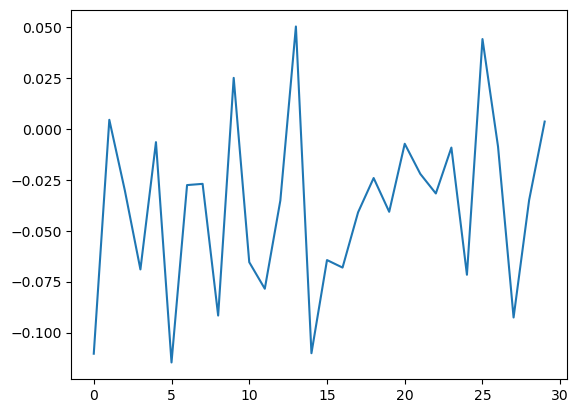

In [ ]:
print(f' NIRS: {nirs_segmented.shape}')
print(f' EEG: {eeg_segmented.shape}')
print(f' event_labels: {event_labels.shape}')

stims = [10003, 10005]
# Get the indexes of the events
event_indexes = [np.where(event_labels == stim)[0] for stim in stims]
event_indexes = np.concatenate(event_indexes)
print(event_indexes.shape)

eeg_indexed = eeg_segmented[:,event_indexes]
print(eeg_indexed.shape)

# Get average erp
eeg_erp = np.mean(eeg_indexed, axis=1)
print(eeg_erp.shape)

# plot erp
plt.plot(eeg_erp.T)
plt.show()

In [ ]:
X = np.hstack((eeg_feature_matrix.to_numpy(), nirs_feature_matrix.to_numpy()))
feature_labels = eeg_feature_matrix.columns.to_list() + nirs_feature_matrix.columns.to_list()
y = event_labels

# Get data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select the top k features based on mutual information
k = 20  # Number of features to select
selector = SelectKBest(mutual_info_classif, k=k)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

# The selector object now contains the information about which features were selected
selected_features = selector.get_support(indices=True)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n_features = X_train.shape[1]
n_classes = np.unique(y).size

print(f'n_features: {n_features}')
print(f'n_classes: {n_classes}')

svm_model = SVC(kernel='linear', C=1.0)  # Start with a linear kernel and default C value
svm_model.fit(X_train, y_train)

# # Define model
# model = LSTMModel(input_dim=n_features, hidden_dim1=128, hidden_dim2=64, output_dim=n_classes, dropout_rate=0.5)

# # Convert the numpy arrays to PyTorch tensors
# X_tensor = torch.from_numpy(X_train).float()
# y_tensor = torch.from_numpy(y_train).float()

# # Create a TensorDataset and DataLoader for batching
# dataset = TensorDataset(X_tensor, y_tensor)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# loss_function = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# for epoch in range(n_epochs):
#     train_loss = 0.0
#     for inputs, targets in dataloader:
#         print(inputs.shape)

#         # Zero the gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         predictions = model(inputs)
        
#         # Compute loss
#         loss = loss_function(predictions, targets)
        
#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item() * inputs.size(0)

#     # Print training and validation loss
#     print(f'Epoch {epoch+1}, Loss: {train_loss}')



n_features: 20
n_classes: 3


SVC(kernel='linear')

In [ ]:
X_test_temp = X_test.copy()
y_test_temp = y_test.copy()

y_pred = svm_model.predict(X_test_temp)
print(f"Accuracy: {accuracy_score(y_test_temp, y_pred)}")
print(classification_report(y_test_temp, y_pred))

Accuracy: 0.5
              precision    recall  f1-score   support

       10001       0.00      0.00      0.00         0
       10004       0.00      0.00      0.00         2
       10007       0.60      0.75      0.67         4

    accuracy                           0.50         6
   macro avg       0.20      0.25      0.22         6
weighted avg       0.40      0.50      0.44         6



/Users/mm/anaconda3/envs/mne/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mm/anaconda3/envs/mne/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mm/anaconda3/envs/mne/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mm/anaconda